# Homework 2 - Berkeley STAT 157

Handout 1/29/2019, due 2/5/2019 by 4pm in Git by committing to your repository.

In [123]:
from mxnet import nd, autograd, gluon
from mxnet import ndarray as nd
import numpy as np
import mxnet as mx
from mxnet import nd
from mxnet.gluon import nn
from functools import reduce
from operator import mul
from matplotlib import pyplot as plt

# 1. Multinomial Sampling

Implement a sampler from a discrete distribution from scratch, mimicking the function `mxnet.ndarray.random.multinomial`. Its arguments should be a vector of probabilities $p$. You can assume that the probabilities are normalized, i.e. tha they sum up to $1$. Make the call signature as follows:

```
samples = sampler(probs, shape) 

probs   : An ndarray vector of size n of nonnegative numbers summing up to 1
shape   : A list of dimensions for the output
samples : Samples from probs with shape matching shape
```

Hints:

1. Use `mxnet.ndarray.random.uniform` to get a sample from $U[0,1]$.
1. You can simplify things for `probs` by computing the cumulative sum over `probs`.

In [86]:
def sampler(probs, shape):
    ## Add your codes here
    cum_probs = np.cumsum(probs.asnumpy())
    
    total = reduce(mul, shape, 1)
    result = nd.zeros((1, total))
    
    for i in range(total):
        temp = nd.random.uniform()
        for j in range(len(cum_probs)):
            if cum_probs[j] > temp:
                result[0, i] = j
                break
    
    result = result.reshape(shape)
    return result

# a simple test

sampler(nd.array([0.2, 0.3, 0.5]), (2,3))


[[2. 2. 1.]
 [2. 2. 1.]]
<NDArray 2x3 @cpu(0)>

# 2. Central Limit Theorem

Let's explore the Central Limit Theorem when applied to text processing. 

* Download [https://www.gutenberg.org/ebooks/84](https://www.gutenberg.org/files/84/84-0.txt) from Project Gutenberg 
* Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
* For the words `a`, `and`, `the`, `i`, `is` compute their respective counts as the book progresses, i.e. 
    $$n_\mathrm{the}[i] = \sum_{j = 1}^i \{w_j = \mathrm{the}\}$$
* Plot the proportions $n_\mathrm{word}[i] / i$ over the document in one plot.
* Find an envelope of the shape $O(1/\sqrt{i})$ for each of these five words. (Hint, check the last page of the [sampling notebook](http://courses.d2l.ai/berkeley-stat-157/slides/1_24/sampling.pdf))
* Why can we **not** apply the Central Limit Theorem directly? 
* How would we have to change the text for it to apply? 
* Why does it still work quite well?

In [131]:
import re

filename = gluon.utils.download('https://www.gutenberg.org/files/84/84-0.txt')
with open(filename) as f:
    book = f.read()

## Add your codes here
book = book.lower()
book = re.sub(r'[^\w\s]','',book)

words = book.split()

count = 0
a_counts = np.zeros((1, len(words)))
and_counts = np.zeros((1, len(words)))
the_counts = np.zeros((1, len(words)))
i_counts = np.zeros((1, len(words)))
is_counts = np.zeros((1, len(words)))

for i in range(1, len(words)):
    count += 1
    if words[i] == "a":
        a_counts[0, i] = a_counts[0,i - 1] + 1
    else:
        a_counts[0, i] = a_counts[0,i - 1]
        
    if words[i] == "and":
        and_counts[0,i] = and_counts[0,i - 1] + 1
    else:
        and_counts[0,i] = and_counts[0,i - 1]
        
    if words[i] == "the":
        the_counts[0,i] = the_counts[0,i - 1] + 1
    else:
        the_counts[0,i] = the_counts[0,i - 1]
        
    if words[i] == "i":
        i_counts[0,i] = i_counts[0,i - 1] + 1
    else:
        i_counts[0,i] = i_counts[0,i - 1]
        
    if words[i] == "is":
        is_counts[0,i] = is_counts[0,i - 1] + 1
    else:
        is_counts[0,i] = is_counts[0,i - 1]

Plot the proportions of the words:

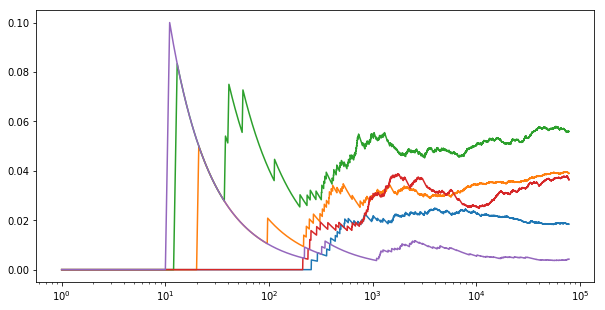

In [130]:
y = np.arange(1, len(words)+1).reshape(len(words),1)
a_props = np.zeros((1, len(words)))
and_props = np.zeros((1, len(words)))
the_props = np.zeros((1, len(words)))
i_props = np.zeros((1, len(words)))
is_props = np.zeros((1, len(words)))

for i in range(1, count+1):
    a_props[0, i] = a_counts[0, i]/i
    and_props[0, i] = and_counts[0, i]/i
    the_props[0, i] = the_counts[0, i]/i
    i_props[0, i] = i_counts[0, i]/i
    is_props[0, i] = is_counts[0, i]/i

plt.figure(figsize=(10,5))
plt.semilogx(y,a_props[0,:])
plt.semilogx(y,and_props[0,:]) 
plt.semilogx(y,the_props[0,:]) 
plt.semilogx(y,i_props[0,:]) 
plt.semilogx(y,is_props[0,:]) 
plt.show()

We cannot apply CLT directly because we don't know if the words are independent in this text file, so the proportion of the words may not perform as the central limit theorem predicts.
To solve this, we can totally randomize the text file, break the order of the words, so that the central limit theorem only focus on the frequency of the word, but not the dependence to some other words.
It still works because Central limit theorem ensures that as long as the dataset is large enough, the frequency of the data will converge to a certain point, and randomized data also works in this condition.

## 3. Denominator-layout notation

We used the numerator-layout notation for matrix calculus in class, now let's examine the denominator-layout notation.

Given $x, y\in\mathbb R$, $\mathbf x\in\mathbb R^n$ and $\mathbf y \in \mathbb R^m$, we have

$$
\frac{\partial y}{\partial \mathbf{x}}=\begin{bmatrix}
\frac{\partial y}{\partial x_1}\\
\frac{\partial y}{\partial x_2}\\
\vdots\\
\frac{\partial y}{\partial x_n}
\end{bmatrix},\quad 
\frac{\partial \mathbf y}{\partial {x}}=\begin{bmatrix}
\frac{\partial y_1}{\partial x}, 
\frac{\partial y_2}{\partial x}, 
\ldots,
\frac{\partial y_m}{\partial x}
\end{bmatrix}
$$

and 

$$
\frac{\partial \mathbf y}{\partial \mathbf{x}}
=\begin{bmatrix}
\frac{\partial \mathbf y}{\partial {x_1}}\\
\frac{\partial \mathbf y}{\partial {x_2}}\\
\vdots\\
\frac{\partial \mathbf y}{\partial {x_3}}\\
\end{bmatrix}
=\begin{bmatrix}
\frac{\partial y_1}{\partial x_1}, 
\frac{\partial y_2}{\partial x_1},
\ldots,
\frac{\partial y_m}{\partial x_1}
\\ 
\frac{\partial y_1}{\partial x_2},
\frac{\partial y_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial x_2}\\ 
\vdots\\
\frac{\partial y_1}{\partial x_n},
\frac{\partial y_2}{\partial x_n},
\ldots,
\frac{\partial y_m}{\partial x_n}
\end{bmatrix}
$$

Questions: 

1. Assume $\mathbf  y = f(\mathbf u)$ and $\mathbf u = g(\mathbf x)$, write down the chain rule for $\frac {\partial\mathbf  y}{\partial\mathbf x}$
2. Given $\mathbf X \in \mathbb R^{m\times n},\ \mathbf w \in \mathbb R^n, \ \mathbf y \in \mathbb R^m$, assume $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, compute $\frac{\partial z}{\partial\mathbf w}$.

1) For the first part we have $\mathbf y=f\left(\begin{bmatrix}
u_1\\
u_2\\
\vdots\\
u_n
\end{bmatrix}\right)$, and $\mathbf u=f\left(\begin{bmatrix}
x_1\\
x_2\\
\vdots\\
x_n
\end{bmatrix}\right)$, we get $\mathbf y=\begin{bmatrix}
f(g(x_1))\\
f(g(x_2))\\
\vdots\\
f(g(x_n))
\end{bmatrix}$
and according to the information we have the formula $\frac{\partial \mathbf y}{\partial \mathbf{x}}$.

So we can plug in the formula, so $\frac{\partial \mathbf y}{\partial \mathbf{x}} 
=\begin{bmatrix}
\frac{\partial y_1}{\partial u_1}\frac{\partial u_1}{\partial x_1}, 
\frac{\partial y_1}{\partial u_2}\frac{\partial u_2}{\partial x_2},
\ldots,
\frac{\partial y_1}{\partial u_n}\frac{\partial u_n}{\partial x_n},
\\ 
\frac{\partial y_2}{\partial u_1}\frac{\partial u_1}{\partial x_1},
\frac{\partial y_2}{\partial u_2}\frac{\partial u_2}{\partial x_2},
\ldots,
\frac{\partial y_2}{\partial u_n}\frac{\partial u_n}{\partial x_n}\\ 
\vdots\\
\frac{\partial y_m}{\partial u_1}\frac{\partial u_1}{\partial x_1},
\frac{\partial y_m}{\partial u_2}\frac{\partial u_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial u_n}\frac{\partial u_n}{\partial x_n}
\end{bmatrix}
$

2) Since we have $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, we can get
$z = 2(\mathbf X \mathbf w - \mathbf y)^T \mathbf X = 
2\left( \begin{bmatrix}
x_{11}, x_{12}, \ldots, x_{1n}\\ 
x_{21}, x_{22}, \ldots, x_{2n}\\ 
\vdots\\
x_{m1}, x_{m2}, \ldots, x_{mn}\\ 
\end{bmatrix}
\begin{bmatrix}
w_1\\w_2\\ \vdots \\ w_n
\end{bmatrix} - 
\begin{bmatrix}
y_1\\y_2\\ \vdots \\ y_m
\end{bmatrix} \right)^T
\begin{bmatrix}
x_{11}, x_{12}, \ldots, x_{1n}\\ 
x_{21}, x_{22}, \ldots, x_{2n}\\ 
\vdots\\
x_{m1}, x_{m2}, \ldots, x_{mn}\\ 
\end{bmatrix} \in \mathbb R^m
$

## 4. Numerical Precision

Given scalars `x` and `y`, implement the following `log_exp` function such that it returns 
$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$.

In [103]:
from math import log
from math import exp
def log_exp(x, y):
    ## add your solution here
    return -log(exp(x.asscalar())/(exp(x.asscalar()) + exp(y.asscalar())))

Test your codes with normal inputs:

In [104]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z

1.3132616875182228

Now implement a function to compute $\partial z/\partial x$ and $\partial z/\partial y$ with `autograd`

In [105]:
def grad(forward_func, x, y): 
    ## Add your codes here
    print('x.grad =', x.grad)
    print('y.grad =', y.grad)

Test your codes, it should print the results nicely. 

In [106]:
grad(log_exp, x, y)

x.grad = None
y.grad = None


But now let's try some "hard" inputs

In [8]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

x.grad = None
y.grad = None


Does your code return correct results? If not, try to understand the reason. (Hint, evaluate `exp(100)`). Now develop a new function `stable_log_exp` that is identical to `log_exp` in math, but returns a more numerical stable result.

In [9]:
def stable_log_exp(x, y):
    ## Add your codes here
    pass

grad(stable_log_exp, x, y)

x.grad = None
y.grad = None
